In [18]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>")) 
import traceback
import datetime
import os
from glob import glob

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42  # to edit text in Illustrator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd
import tqdm
import warnings

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.signal import PPSD
import pandas as pd
import seaborn as sns
from scipy import stats

In [19]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

In [20]:
timings = pd.read_csv(r"Supplementary Files/Table S1 - Lockdown stations.csv", encoding='latin-1', parse_dates=["Date_LD1", "Date_LD2"], dayfirst=True,
                     index_col="Station_Code")
timings = timings.sort_values(["Date_LD1", "Country code", "City"])
print(timings.head())

                               Country name Country code         City  \
Station_Code                                                            
AM.R3EE8                             Taiwan           TW  Taipei City   
IC.BJT                    Republic of China           CN      Beijing   
IC.ENH                    Republic of China           CN        Enshi   
IC.QIZ                    Republic of China           CN  Hainan Prov   
IC.HIA        Republic of Republic of China           CN    Neimenggu   

              pop_den_30s  pop_den_2.5min        FDSN plotted_in_fig2  \
Station_Code                                                            
AM.R3EE8           9167.0         13861.0  RASPISHAKE             Yes   
IC.BJT             1329.0          1513.0        IRIS             Yes   
IC.ENH              430.0          3563.0        IRIS             Yes   
IC.QIZ              271.0           233.0        IRIS             Yes   
IC.HIA             1557.0          2098.0        I

In [21]:
files = sorted(glob(r"PaperZero_RMS/*Z.csv"))
print("There are %i **Z CSV files in the folder" % len(files))
netsta = []
seedid = []
for f in files:
    n,s,l,c,csv = os.path.split(f)[1].split(".")
    netsta.append("%s.%s" % (n,s))
    seedid.append(os.path.split(f)[1].replace(".csv",""))

There are 172 **Z CSV files in the folder


In [22]:
checked_FDSN = {}

In [23]:
# #this is not needed to plot the pre-processed data# for sd, ns in zip(seedid, netsta):
#     _ = timings.filter(like=ns, axis=0)
#     if not(len(_)):
#         print("%s not found in the timing/time_zone data" % ns)
#         continue
#     if sd in checked_FDSN:
#         continue
#     print(ns, sd, "-->", _.iloc[0].FDSN)
#     n,s,l,c = sd.split(".")
#     if n == "YS":
#         continue
#     try:
#         client = Client(_.iloc[0].FDSN)
#         resp = client.get_stations(network=n, station=s, location=l, channel=c, starttime=UTCDateTime("2019-12-01"), level='response')
#         checked_FDSN[sd] = True
#         del client
#     except:
#         print("%s: ERROR cannot access: %s" % (sd, _.iloc[0].FDSN))
#         print()

In [24]:
data = {}
LD1 = []
LD2 = []
LOC = []
labels_left = []
labels_right = []
country_code = []

for seedid, row in timings.iterrows():
    code = seedid
    if code == "":
        continue
    if code in data:
        continue
    try:
        netsta = "%s.%s" % (code.split(".")[0], code.split(".")[1])
    except:
        continue
    files = glob(r"PaperZero_RMS/%s.*.*Z.csv" % netsta)
    if not len(files):
        continue

    file = files[0]
    print("Processing %s, %s - LD1: %s" % (code, file, row["Date_LD1"]))
    df = pd.read_csv(file, index_col=0, parse_dates=True, dayfirst=True)
    if not len(df):
        continue
    if netsta == "HE.HEL2":
        # Special case for Helsinki, very high freqs
        df = df.loc[:,"60.0-90.0"].to_frame()
    elif len(df.columns) != 1:
        try:
            # default case should be 4.0-14.0
            df = df.loc[:,"4.0-14.0"].to_frame()
        except:
            # otherwise the last column is taken
            df = df.loc[:,df.columns[-2]].to_frame()
    
    df.columns = [code,]
    # Localize the observations to a standard 24h day
    try:
        df = df.tz_localize("UTC").tz_convert(row["TimeZone"]).tz_localize(None)
    except:
        try:
            df = df.tz_convert(row["TimeZone"]).tz_localize(None)
        except:
            print("ERROR ERRORERRORERRORERROR with %s" % row["TimeZone"])
            traceback.print_exc()
            df = df.tz_localize(None)
    
    # Take the daily median value
    df = df.resample("1D").median()
    
    # Normalize between percentiles 15 and 85 of "before lockdown"
    if not pd.isnull(row["Date_LD1"]):
        preloc = df.loc[:row["Date_LD1"]].copy()
        df -= preloc.quantile(0.15)
        preloc -= preloc.quantile(0.15)
        df /= preloc.quantile(0.85)
    else:
        df -= df.quantile(0.15)
        df /= df.quantile(0.85)
    
    # Clip the outliers
    df = df.clip(None, df.quantile(0.98), axis=1)
    data[code] = df
    LD1.append(row["Date_LD1"])
    LD2.append(row["Date_LD2"])
    LOC.append(row["City"])
    country_code.append(row["Country code"])
    labels_left.append("%s - %s" % (row["City"], row["Country code"]))
    labels_right.append(code)
    del df
print("There are %i dataframes loaded" % len(data))

Processing AM.R3EE8, PaperZero_RMS/AM.R3EE8.00.EHZ.csv - LD1: 2020-01-21 00:00:00
Processing IC.BJT, PaperZero_RMS/IC.BJT.10.HHZ.csv - LD1: 2020-01-23 00:00:00
Processing IC.ENH, PaperZero_RMS/IC.ENH.10.HHZ.csv - LD1: 2020-01-23 00:00:00
Processing IC.QIZ, PaperZero_RMS/IC.QIZ.10.HHZ.csv - LD1: 2020-01-24 00:00:00
Processing IC.HIA, PaperZero_RMS/IC.HIA.10.HHZ.csv - LD1: 2020-01-24 00:00:00
Processing AM.REAF3, PaperZero_RMS/AM.REAF3.00.EHZ.csv - LD1: 2020-01-25 00:00:00
Processing HK.HKPS, PaperZero_RMS/HK.HKPS..HHZ.csv - LD1: 2020-01-25 00:00:00
Processing IC.LSA, PaperZero_RMS/IC.LSA.10.HHZ.csv - LD1: 2020-01-29 00:00:00
Processing AM.S4458, PaperZero_RMS/AM.S4458.00.EHZ.csv - LD1: 2020-02-23 00:00:00
Processing AM.R3E8F, PaperZero_RMS/AM.R3E8F.00.EHZ.csv - LD1: 2020-02-23 00:00:00
Processing AC.VLO, PaperZero_RMS/AC.VLO..HHZ.csv - LD1: 2020-03-08 00:00:00
Processing IV.MILN, PaperZero_RMS/IV.MILN..HHZ.csv - LD1: 2020-03-08 00:00:00
Processing AM.RFBE4, PaperZero_RMS/AM.RFBE4.00.EHZ

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


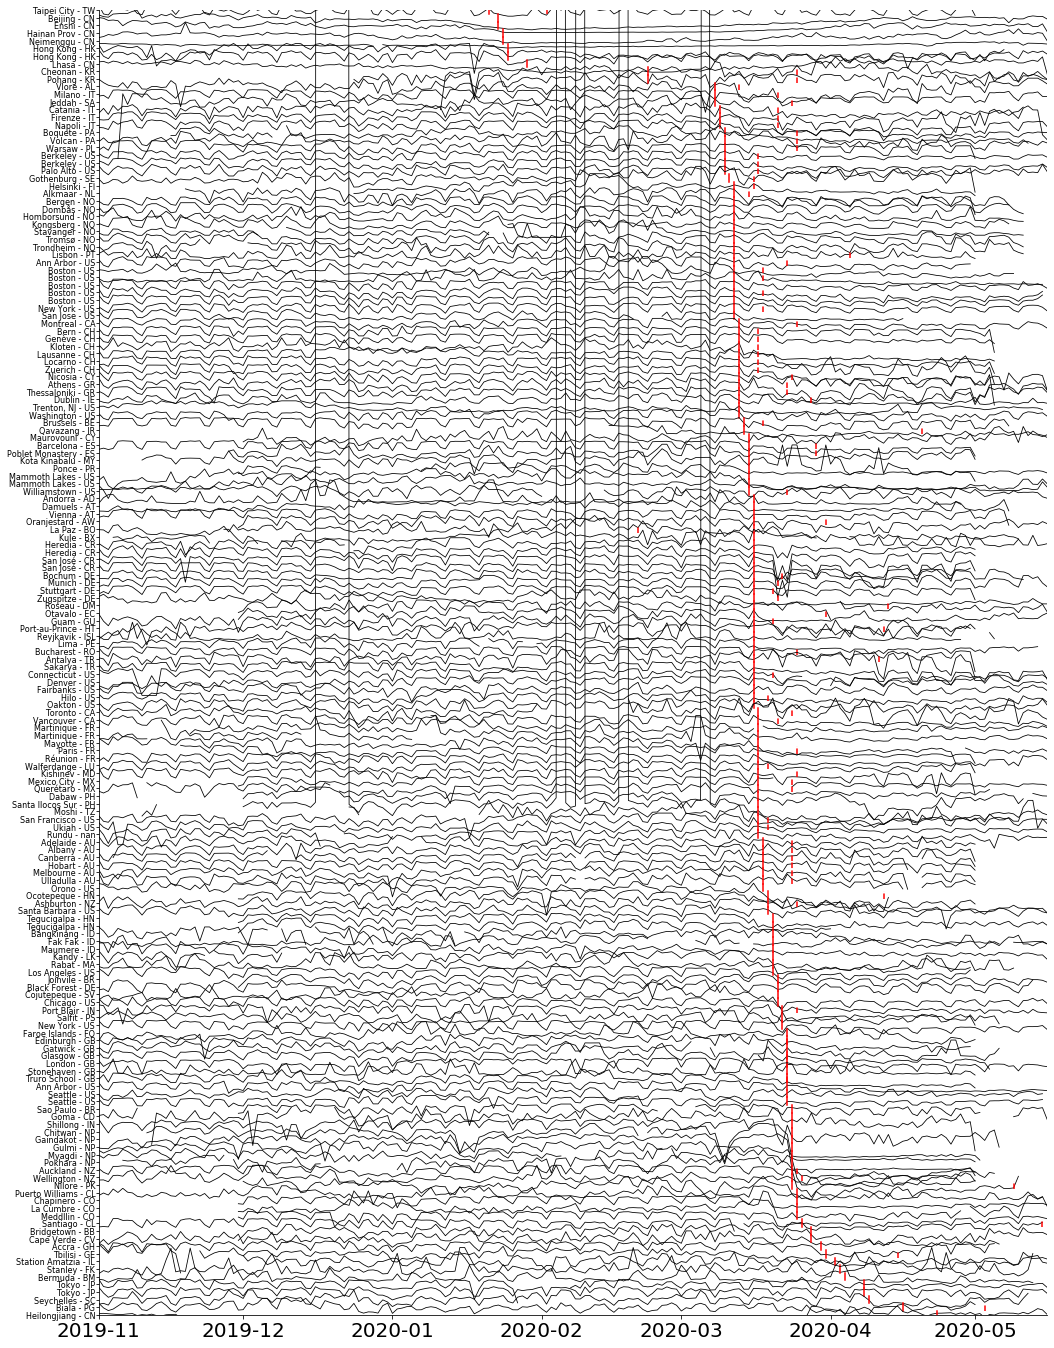

In [25]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(17,24))
for i, key in enumerate(data):

    df = data[key].copy()
    plt.plot(df.index, df -i -.5, c='k', lw=0.8)

    try:
        plt.plot([LD1[i], LD1[i]],[-i-0.5, -i+0.5], c='r')
    except:
        pass
    try:
        plt.plot([LD2[i], LD2[i]],[-i-0.5, -i+0.5], c='r', ls='--')
    except:
        pass
 


ax.set_yticks(-np.arange(len(data.keys())), minor=False)
ax.set_yticklabels(labels_left, minor=False, ha='right', fontsize=8)
ax.get_yaxis().set_tick_params(pad=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.grid(False)
plt.ylim(-i,0)
plt.margins(0)

plt.xlim(UTCDateTime("2019-11-01").datetime, df.index[-1])
plt.show()

In [26]:
# Concatenate all time series in a 2D array for plotting Figure S1 and Figure 2

a = pd.concat(data, axis=1)
a = a.droplevel(0, axis=1)

# Export data for making the video
a.loc["2019-11-01":].to_csv("FIGURE2_DATA.csv")

In [27]:
def plot_figure_S1(colormap, show=True, save=False):
    matplotlib.rcParams['ytick.labelsize'] = 10.5
    matplotlib.rcParams['xtick.labelsize'] = 13
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['font.sans-serif'] = 'Tahoma' 
    x = a.index.copy()
    y = np.arange(len(labels_left))
    fig, ax = plt.subplots(1,1, figsize=(17,24))
    plt.pcolormesh(x, y, a.T, vmin=0.00, vmax=1.5, cmap=colormap, antialiased=True, rasterized=True)
    plt.colorbar(orientation="horizontal", shrink=0.5, pad=0.02).set_label("Normalized Amplitude", fontsize=12)
    for i, L in enumerate(LD1):
        if not pd.isnull(L):
            plt.scatter(L, i+0.5, marker="o", c='w', )
    for i, L in enumerate(LD1):
        if not pd.isnull(L):
            plt.scatter(L, i+0.5, marker="o", facecolor='w',edgecolor="k", label="Lockdown Date", zorder=-10, s=100)
            break
    plt.legend(loc=3, fontsize=22, frameon=True, framealpha=1)

    plt.yticks(y+0.5, labels_left)
    plt.margins(0)
    plt.xlim(UTCDateTime("2019-12-01").datetime, UTCDateTime("2020-05-05").datetime)
    plt.gca().invert_yaxis()
    plt.grid(True, axis='y')
    ax.set_axisbelow(True)
    sns.despine()
    ax2 = plt.twinx()
    plt.yticks(y+0.5, labels_right)
    plt.ylim(ax.get_ylim())
    make_patch_spines_invisible(ax2)
    ax2.set_axisbelow(True)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.000)
    if save:
        plt.savefig(r"FIGURE_S1_%s.png"%colormap, dpi=300,bbox_inches="tight", pad_inches=0)
    if show:
        plt.show()
        plt.close("all")


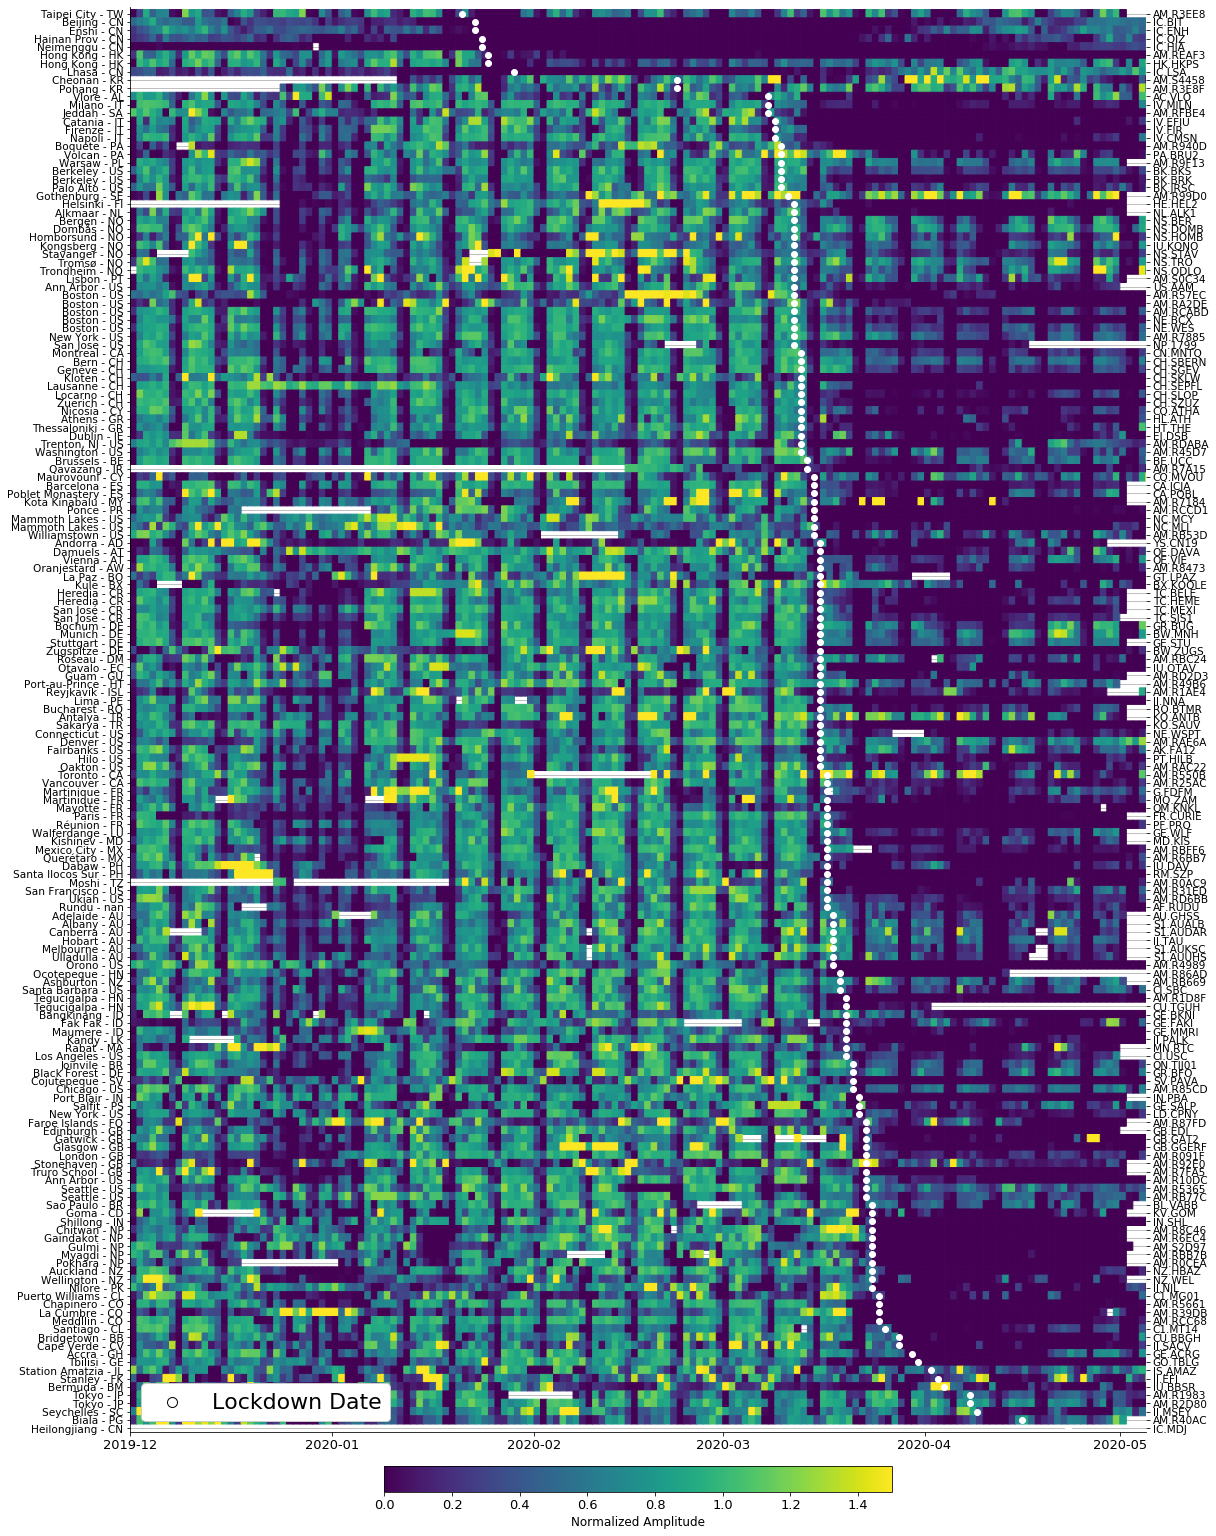

In [28]:
plot_figure_S1("viridis", show=True, save=False)

In [29]:
def plot_figure_2(colormap, show=True, save=False):
    matplotlib.rcParams['ytick.labelsize'] = 21
    matplotlib.rcParams['xtick.labelsize'] = 20
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['font.sans-serif'] = 'Tahoma' 
    
    dataset = a.copy()
    ix = np.arange(len(dataset.columns))
    dataset = dataset.iloc[:,ix]
    LL = np.array(labels_left)[ix]
    LR = LL[1::2]
    LR = ["%s - %s" % (L.split(" - ")[1], L.split(" - ")[0]) for L in LR]
    LL = LL[::2]
  

    LDS = np.array(LD1)[ix]

    
    x = dataset.index.copy()
    y = np.arange(len(dataset.columns))
    
    YR = y[1::2]
    YL = y[::2]
    
    fig, ax = plt.subplots(1,1, figsize=(17,25))
    plt.pcolormesh(x, y, dataset.T, vmin=0.00, vmax=1.5, cmap=colormap, antialiased=True, rasterized=True)
    plt.colorbar(orientation="horizontal", shrink=0.5, pad=0.02).set_label("Normalized Amplitude", fontsize=19)
    for i, L in enumerate(LDS):
        if not pd.isnull(L):
            plt.scatter(L, i+0.5, marker="o", c='w', )
    for i, L in enumerate(LDS):
        if not pd.isnull(L):
            plt.scatter(L, i+0.5, marker="o", facecolor='w',edgecolor="k", label="Lockdown Date", zorder=-10, s=100)
            break
    plt.legend(loc=3, fontsize=22, frameon=True, framealpha=1)

    for i in range(len(y)):
        plt.plot(x, np.ones(len(x))*i+0.5, lw=0.5, c='silver', zorder=-1)

    plt.yticks(YL+0.5, LL)
    plt.margins(0)
    plt.xlim(UTCDateTime("2019-12-01").datetime, UTCDateTime("2020-05-05").datetime)
    plt.gca().invert_yaxis()

    ax.set_axisbelow(True)
    sns.despine()
    ax2 = plt.twinx()
    plt.yticks(YR+0.5, LR)
    plt.ylim(ax.get_ylim())
    make_patch_spines_invisible(ax2)
    ax2.set_axisbelow(True)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.000)
    if save:
        plt.savefig(r"FIGURE2.png"%colormap, dpi=300,bbox_inches="tight", pad_inches=0)
    if show:
        plt.show()
        plt.close("all")


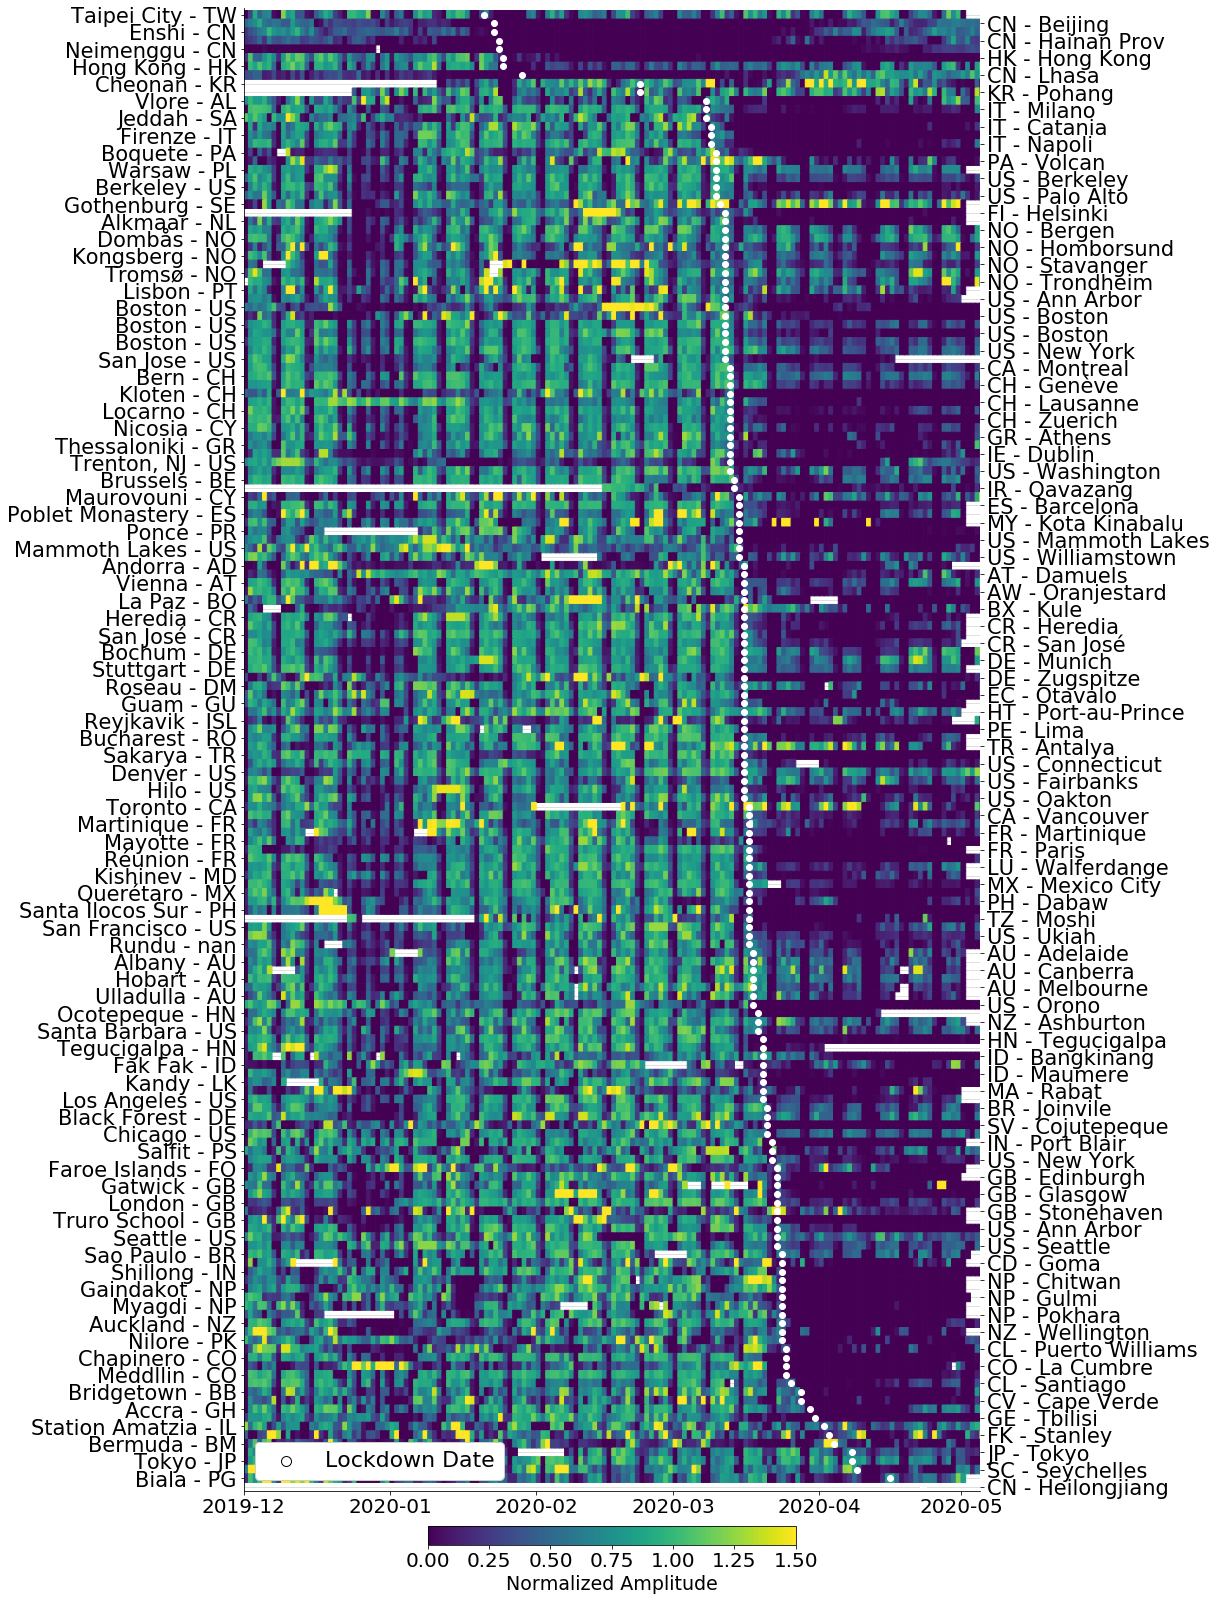

In [30]:
plot_figure_2("viridis", show=True, save=False)

# Global Mobility vs Seismic Noise

In [31]:
fn = "Other_Data/Global_Mobility_Report.csv"
if not os.path.isfile(fn):
    print("We cannot distribute the Google file, please download it and name it %s" % fn)
else:
    google = pd.read_csv(fn, parse_dates=True)
    google = google.copy().set_index("date")
    google = google.groupby(["country_region_code", "date"],).mean()
    google = google.groupby(level=1).median()
    google.index = pd.DatetimeIndex(google.index)
    google.columns = [c.replace("percent_change_from_baseline","").replace("_", " ").strip() for c in google.columns]
    print(google.head())

We cannot distribute the Google file, please download it and name it Other_Data/Global_Mobility_Report.csv


In [32]:
fn = "Other_Data/applemobilitytrends.csv"
if not os.path.isfile(fn):
    print("We cannot distribute the Apple file, please download it and name it %s" % fn)
else:
    apple= pd.read_csv(fn, parse_dates=True)
    apple = apple[apple.geo_type == "country/region"] #.set_index("transportation_type").T.iloc[3:]
    apple = apple.groupby(['transportation_type', 'region']).mean().T
    apple = apple.groupby(level=0, axis=1).median()
    apple.index = pd.DatetimeIndex(apple.index)
    # apple.columns = ["A: %s" % s for s in apple.columns]
    print(apple.head())


We cannot distribute the Apple file, please download it and name it Other_Data/applemobilitytrends.csv


In [33]:
def get_corr_coef(compare):
    compare.columns = ["seismic", "other"]
    bins = np.arange(-200,200,10)
    ix = pd.cut(compare["other"], bins, retbins=True, labels=False)
    compare["other"] = bins[ix[0].astype(int)]
    compare = compare.groupby("other").describe()
    compare = compare.sort_index()
    compare = compare[compare.seismic["count"] >= 3]
    slope, intercept, r_value, p_value, std_err = stats.linregress(compare.index,compare.seismic["mean"])
    return compare, r_value

NameError: name 'mobility' is not defined

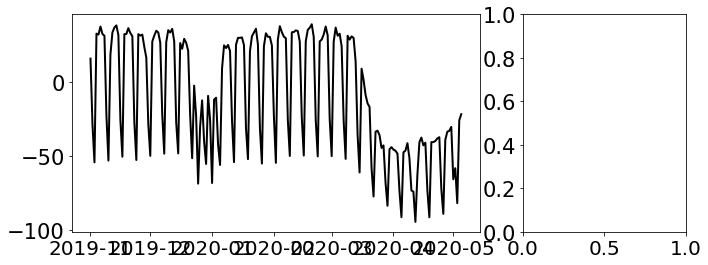

In [34]:
data = ((100*a.loc["2019-11-01":"2020-05-05"])-50).median(axis=1)
data.index = pd.DatetimeIndex(data.index)

fig, axes = plt.subplots(1,2, figsize=(11,4), gridspec_kw={"width_ratios":(5,2), "wspace":0.15})
plt.sca(axes[0])
plt.plot(data.index, data, label="Median of all stations", c="k", lw=2)

for c in mobility.columns:
    compare = pd.concat((data, mobility[c], ), axis=1).dropna()
    _, r_value = get_corr_coef(compare)
    plt.plot(mobility.index, mobility[c], label="%s (r= %.2f)" % (c, r_value), lw=1)


plt.ylabel("Percent Change")

dr = pd.date_range("2019-11-01", "2020-05-15", freq='W-SUN')
for d in dr:
    plt.axvline(d, c='silver', ls='--', )
plt.axvline(d, c='silver', ls='--', label="Sundays")


plt.axvline(UTCDateTime("2019-12-25").datetime, c='r', ls='--', label="Christmas/New Year")
plt.axvline(UTCDateTime("2020-01-01").datetime, c='r', ls='--')
plt.xlabel(" ")

plt.legend(title="Seismic Noise & Mobility", loc=3, ncol=1, fontsize=9)
plt.margins(0)
plt.xlim(UTCDateTime("2019-11-01").datetime, UTCDateTime("2020-05-05").datetime, )

plt.sca(axes[1])
axes[1].set_aspect("equal")
for c in mobility.columns:
    compare = pd.concat((data, mobility[c], ), axis=1).dropna()
    compare, r_value = get_corr_coef(compare)
    plt.scatter(compare.index, compare.seismic["mean"], label="%s (r= %.2f)" % (c.strip(), r_value))


plt.xlim(-80,40)
plt.ylim(-80,40)


plt.ylabel("Seismic Noise Change (%)")
plt.xlabel("Mobility Change (%)")
# plt.grid(True)
plt.tight_layout()
plt.subplots_adjust(right=0.99, left=0.06, hspace=0.00, wspace=0)
# plt.savefig(r"FIGURE4.png", dpi=300, transparent=True)